# Model Interpretability
We'll interpret our model's predictions using LIME (Local Interpretable Model-agnostic Explanations). LIME helps us understand which words in a review most strongly influence the model's classification decisions.
We start by copying the necessary code we need from the previous notebook so we can start interpreting using LIME.


In [14]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


processed_path = "../../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)
df['label'] = df['polarity'].map({1: 0, 2: 1})
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model = load_model('../../models/cnn/best_model.keras')
with open('../../models/cnn/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

maxlen = 70  


Now we'll use LIME to analyze how the model makes its decisions and then visualize which words contribute most to positive/negative sentiment predictions.
We'll create a prediction function that:
1. Converts text to sequences using our tokenizer
2. Pads sequences to the required length
3. Gets predictions from our model
4. Returns probabilities for both negative and positive classes.

Finally, we'll display the models prediction, showing the original text, the top words that influenced the prediction, and list the contribution score for each word

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

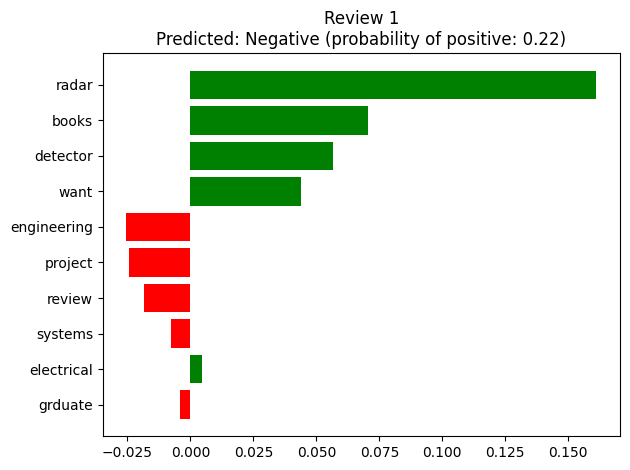


Review 1:
Text: radar detection want review books obout radar systems radar detection curcuits radar detector avalia...

Top contributing words:
radar: 0.161
books: 0.071
detector: 0.056
want: 0.044
engineering: -0.025
project: -0.024
review: -0.018
systems: -0.008
electrical: 0.005
grduate: -0.004


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Figure size 1000x400 with 0 Axes>

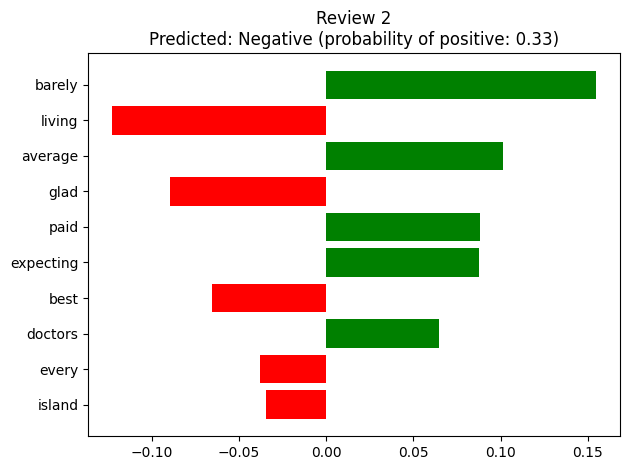


Review 2:
Text: arent many think new long island glad find book claiming identify physicians expertise used book sel...

Top contributing words:
barely: 0.155
living: -0.123
average: 0.101
glad: -0.089
paid: 0.088
expecting: 0.087
best: -0.066
doctors: 0.065
every: -0.038
island: -0.035


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Figure size 1000x400 with 0 Axes>

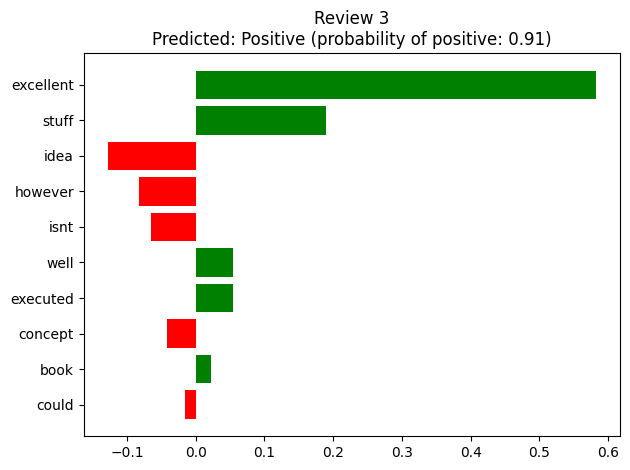


Review 3:
Text: excellent stuff whole idea book film clever well executed concept however americans could believe pa...

Top contributing words:
excellent: 0.582
stuff: 0.190
idea: -0.128
however: -0.082
isnt: -0.065
well: 0.055
executed: 0.054
concept: -0.042
book: 0.022
could: -0.016


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<Figure size 1000x400 with 0 Axes>

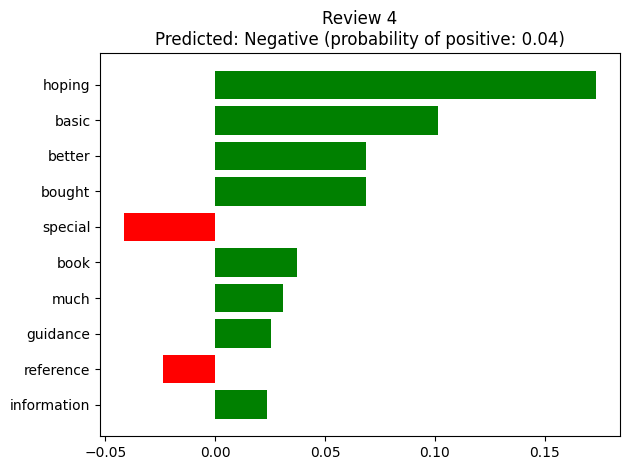


Review 4:
Text: basic guide bought book hoping find guidance establishing special needs trust basic information easi...

Top contributing words:
hoping: 0.174
basic: 0.101
better: 0.069
bought: 0.069
special: -0.042
book: 0.037
much: 0.031
guidance: 0.025
reference: -0.024
information: 0.024


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

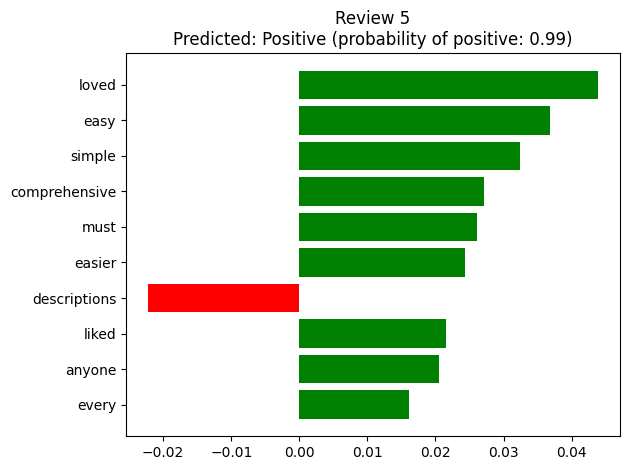


Review 5:
Text: easytounderstand book estate planning loved book simple descriptions every aspect estate planning ea...

Top contributing words:
loved: 0.044
easy: 0.037
simple: 0.032
comprehensive: 0.027
must: 0.026
easier: 0.024
descriptions: -0.022
liked: 0.022
anyone: 0.021
every: 0.016




In [15]:
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

#function to predict probabilities
def predict_prob(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    preds = best_model.predict(padded)
    return np.array([[1-p[0], p[0]] for p in preds])

#create LIME explainer and get sample texts
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
num_examples = 5
sample_indices = np.random.choice(len(X_test), num_examples)
sample_texts = X_test.iloc[sample_indices].values

#nalyze each example
for idx, text in enumerate(sample_texts):
    exp = explainer.explain_instance(
        text, 
        predict_prob,
        num_features=10,
        top_labels=1
    )
    
    pred_probs = predict_prob([text])[0]
    pred_class = 'Positive' if pred_probs[1] > 0.5 else 'Negative'
    explained_label = exp.available_labels()[0]
    plt.figure(figsize=(10, 4))
    exp.as_pyplot_figure(label=explained_label)
    plt.title(f'Review {idx+1}\nPredicted: {pred_class} (probability of positive: {pred_probs[1]:.2f})')
    plt.tight_layout()
    plt.show()
    
    print(f"\nReview {idx+1}:")
    print(f"Text: {text[:100]}...")
    print("\nTop contributing words:")
    for word, score in exp.as_list(label=explained_label):
        print(f"{word}: {score:.3f}")
    print("\n" + "="*50 + "\n")